In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [2]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [4]:
#모델이 deeplabv3_xception_tf_dim_ordering_tf_kernels.h5 
#이름으로 이미 다운이 받아져있다. 
#따라서 모델 파일명을 사용하여 세그멘테이션 모델을 생성하려고한다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
#Pixelib로 사용할 세그멘테이션 모델을 생성하기
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [5]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [6]:
# 컬러맵 만들기
def make_segmap(output):
    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    print(colormap[15]) #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
    seg_color = (colormap[15,2],colormap[15,1],colormap[15,0])
    
    # seg_color로만 이루어진 mask만들기!!!

    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
    # cmap 값을 변경하면 다른 색상으로 확인이 가능함
    seg_map = np.all(output==seg_color, axis=-1) 
    return seg_map

In [8]:
def img_separation(img_orig, seg_map):
    # 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    
    return img_show, img_mask

In [24]:
def blur_only_bg(img_mask, img_orig_blur):
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    return img_mask_color, img_bg_blur

In [25]:
def blur_only_object(img_mask, img_orig_blur):
    img_mask = cv2.bitwise_not(img_mask)
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_obj_blur = cv2.bitwise_or(img_origin_blur, img_mask_color)
    return img_mask_color, img_obj_blur

### 단순한 배경에 사람 한명 vs 복잡한 배경에 사람 한명

(848, 840, 3)


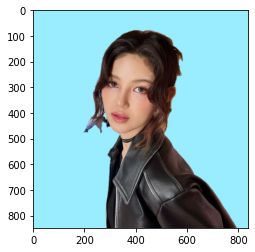

In [12]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/simple_bg_person.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [13]:
seg_v, output = model.segmentAsPascalvoc(img_path)

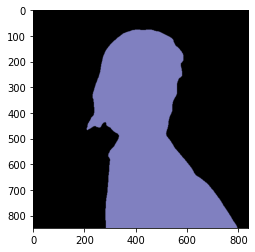

In [14]:
#output 보여주기
plt.imshow(output)
plt.show()

In [15]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [16]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(848, 840)


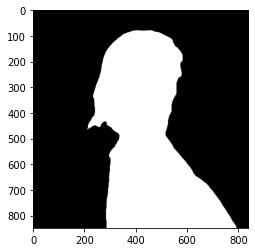

In [17]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

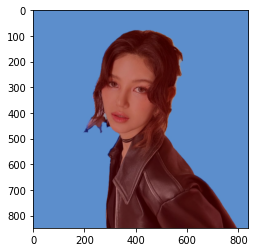

In [18]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

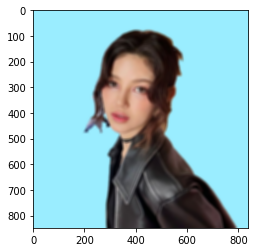

In [19]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

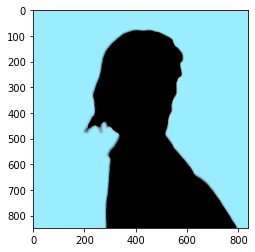

In [26]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

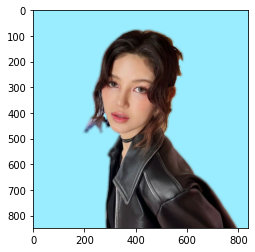

In [27]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 복잡한 배경

(722, 716, 3)


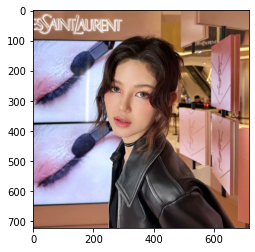

In [28]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/complex_bg_person.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [29]:
seg_v, output = model.segmentAsPascalvoc(img_path)

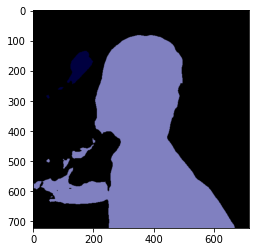

In [30]:
#output 보여주기
plt.imshow(output)
plt.show()

In [31]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0,  8, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [32]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person


[192 128 128]
(722, 716)


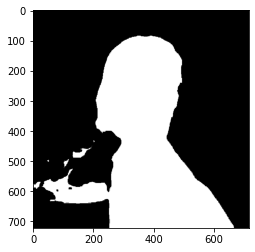

In [33]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

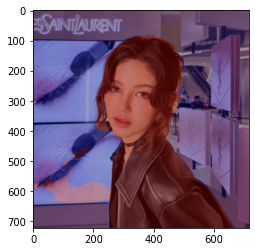

In [34]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

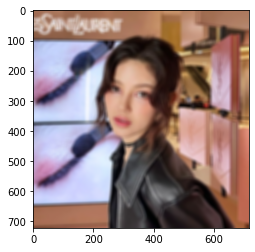

In [35]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

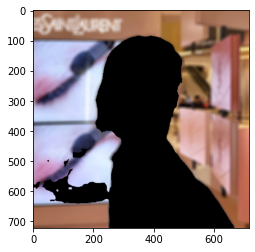

In [36]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

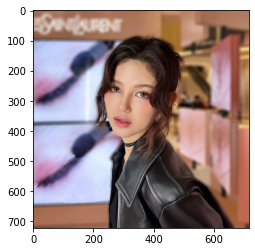

In [37]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

결과물에서는 딱히 큰 이상은 없어보이지만 마스크를 보게되면 다른 부분도 사람으로 인식하거나 고양이가 아닌데 고양이로 인식하는 경우가 있는 것 같다.

### 배경에 따라 사람이 여러명있는 사진에서는 어떻게 나올까?

(866, 1524, 3)


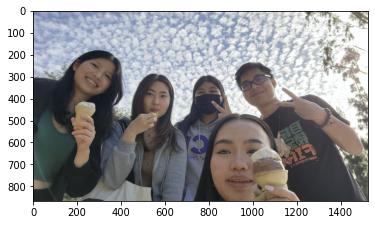

In [58]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/friends_group.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [59]:
seg_v, output = model.segmentAsPascalvoc(img_path)

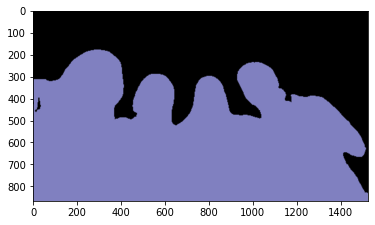

In [60]:
#output 보여주기
plt.imshow(output)
plt.show()

In [61]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [62]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(866, 1524)


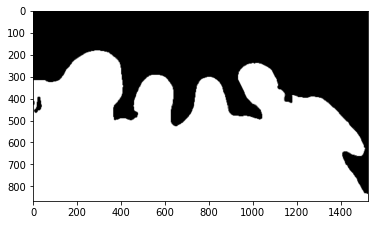

In [63]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

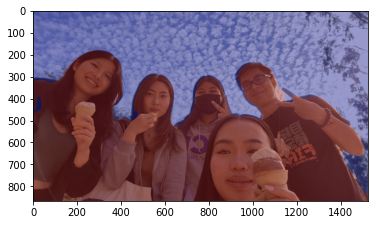

In [64]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

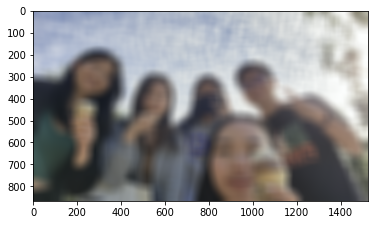

In [65]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

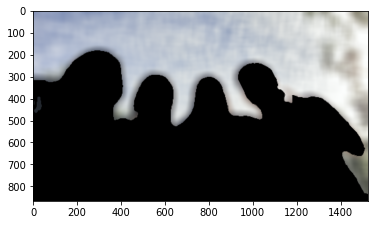

In [66]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

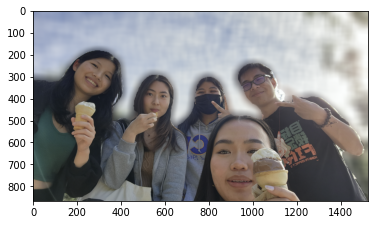

In [67]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

위 사진의 경우 배경이 너무 간단해서 사람들을 쉽게 인식하는 것이 아닐까 생각이 든다. 배경이 조금 더 복잡한 걸 써보려고한다.

(982, 992, 3)


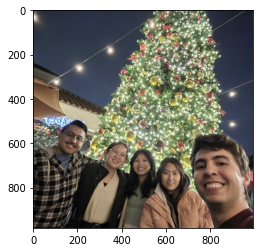

In [68]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/group_of_ppl.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [69]:
seg_v, output = model.segmentAsPascalvoc(img_path)

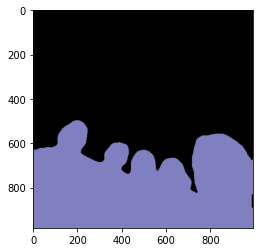

In [70]:
#output 보여주기
plt.imshow(output)
plt.show()

In [71]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [72]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(982, 992)


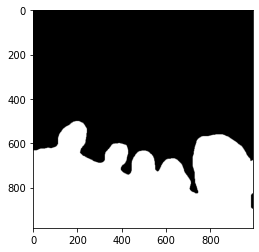

In [73]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

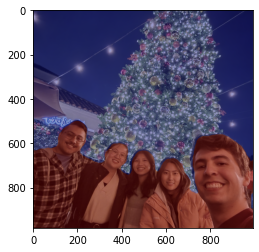

In [74]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

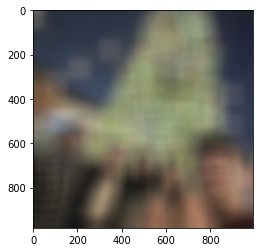

In [75]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (100,100))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

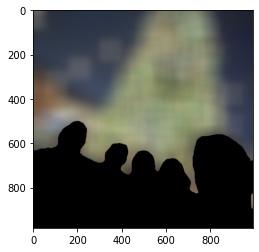

In [76]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

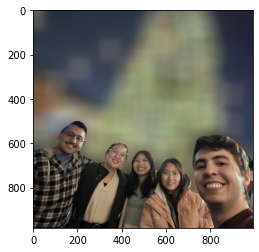

In [77]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

사진 자체가 흐린것 같아 blur filter에 값을 높게 넣어서 해보았다. 사람들의 형체가 주변 사물과 딱히 얽혀있지 않아 사람과 배경을 잘 구별해내는것같다.

* 많은 사람들과 패턴같은 배경이 섞여진다면 어떻게 나올까?

(1126, 770, 3)


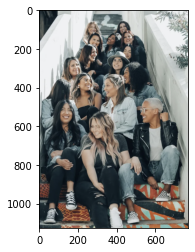

In [78]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/many_ppl_complex_bg.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [79]:
seg_v, output = model.segmentAsPascalvoc(img_path)

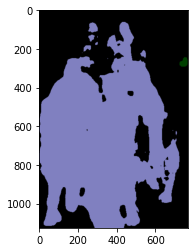

In [80]:
#output 보여주기
plt.imshow(output)
plt.show()

In [81]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [82]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


[192 128 128]
(1126, 770)


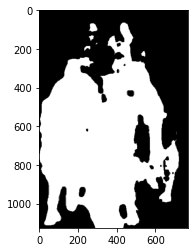

In [83]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

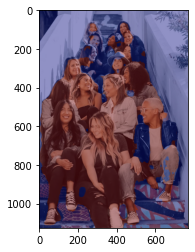

In [84]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

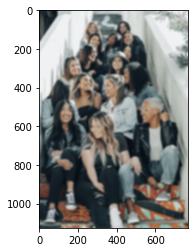

In [85]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

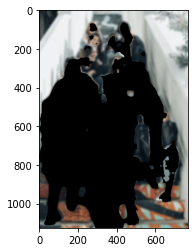

In [86]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

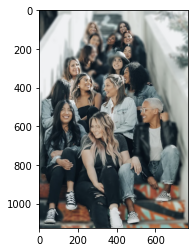

In [87]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

계단의 패턴과는 상관없이 사람이 매우 많을 때는 사람들을 전부 인식하지는 못하는 것 같다.

### 한 사람일경우 사람 몸 전체가 나온 사진 vs 상체만 나온 사진

(828, 464, 3)


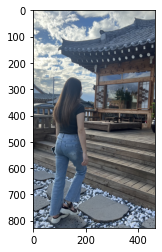

In [88]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/single_person.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [90]:
seg_v, output = model.segmentAsPascalvoc(img_path)

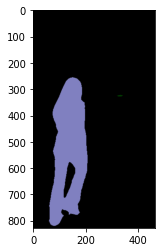

In [91]:
#output 보여주기
plt.imshow(output)
plt.show()

In [92]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [93]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


[192 128 128]
(828, 464)


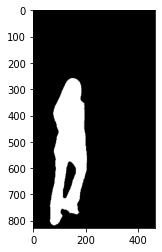

In [94]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

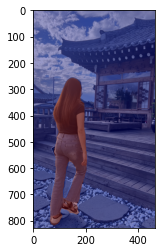

In [95]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

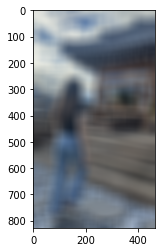

In [99]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

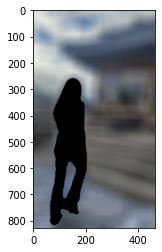

In [100]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

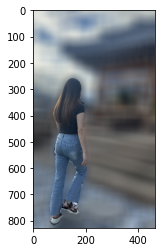

In [101]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(582, 450, 3)


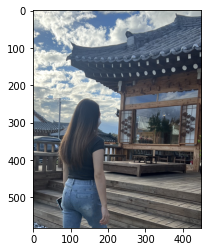

In [116]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/single_person_not_full.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [117]:
seg_v, output = model.segmentAsPascalvoc(img_path)

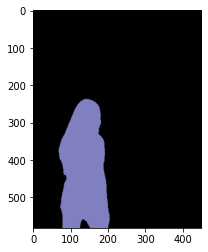

In [118]:
#output 보여주기
plt.imshow(output)
plt.show()

In [119]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [120]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(582, 450)


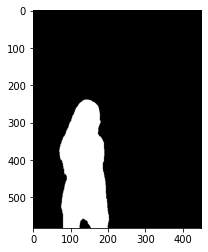

In [121]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

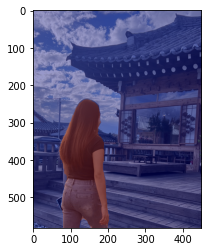

In [122]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

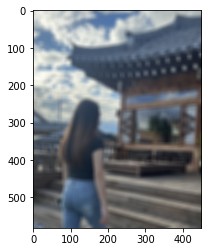

In [123]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

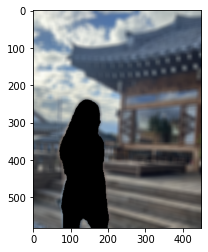

In [124]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

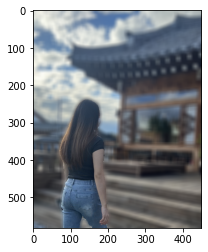

In [125]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

같은 사진에서도 몸 전체가 다 보이게, 상체만 보이게 조정해서 실험을 해봤다. 둘 다 예상대로 제대로 된 결과가 나온 것으로 보아 상체든 전체든 사람으로 인식을 잘하는 걸 알 수 있다.

### 밝은 바탕일때 vs 흑백일때 vs 독특한 조명일때 

* 원본 바탕

(834, 660, 3)


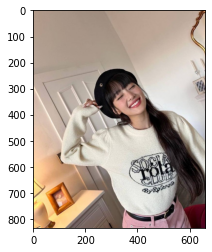

In [102]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/original_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [103]:
seg_v, output = model.segmentAsPascalvoc(img_path)

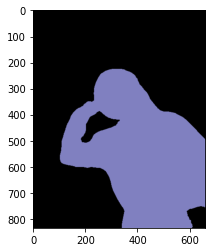

In [104]:
#output 보여주기
plt.imshow(output)
plt.show()

In [106]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [107]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(834, 660)


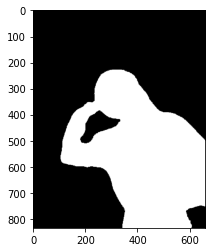

In [108]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

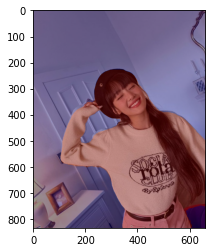

In [109]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

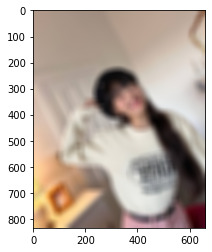

In [113]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (30,30))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

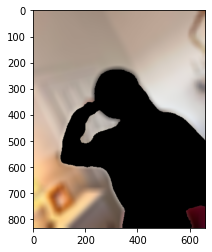

In [114]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

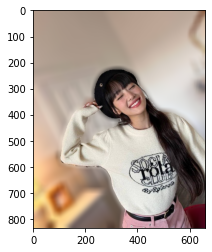

In [115]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 흑백 사진

(838, 672, 3)


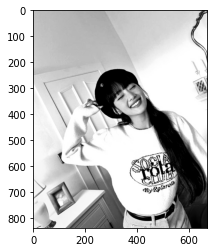

In [126]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/gray_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [127]:
seg_v, output = model.segmentAsPascalvoc(img_path)

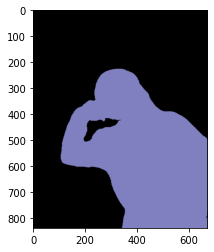

In [128]:
#output 보여주기
plt.imshow(output)
plt.show()

In [129]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [130]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(838, 672)


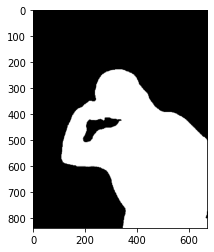

In [131]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

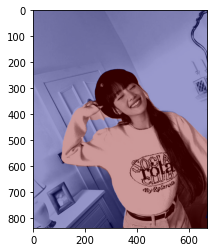

In [132]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

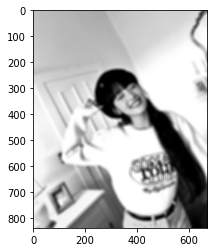

In [133]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

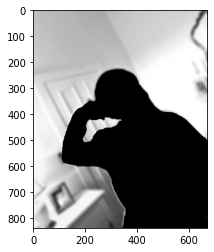

In [134]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

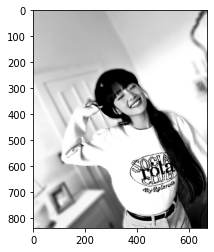

In [135]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 빨간색

(832, 654, 3)


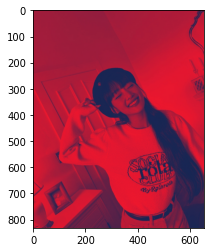

In [136]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/red_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [137]:
seg_v, output = model.segmentAsPascalvoc(img_path)

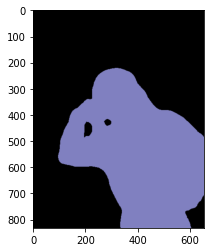

In [138]:
#output 보여주기
plt.imshow(output)
plt.show()

In [139]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [140]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(832, 654)


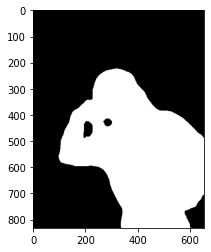

In [141]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

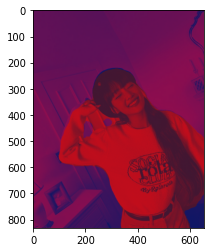

In [142]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

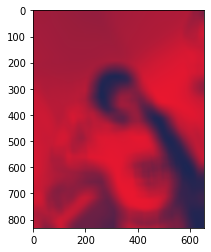

In [143]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (60,60))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

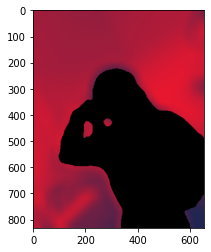

In [144]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

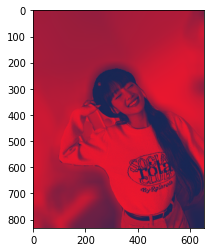

In [145]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* orange 컬러

(822, 664, 3)


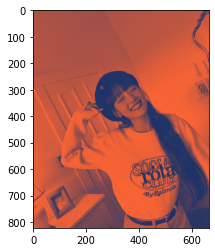

In [146]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/orange_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [147]:
seg_v, output = model.segmentAsPascalvoc(img_path)

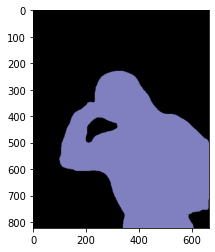

In [148]:
#output 보여주기
plt.imshow(output)
plt.show()

In [149]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [150]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(822, 664)


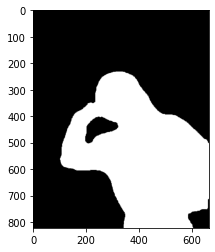

In [151]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

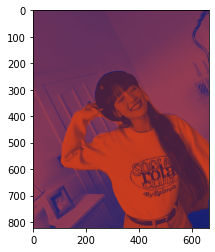

In [152]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

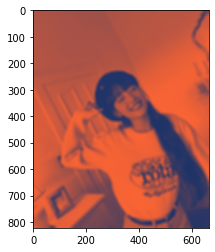

In [153]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

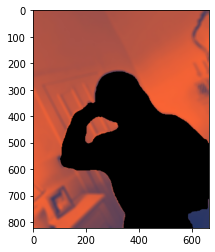

In [154]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

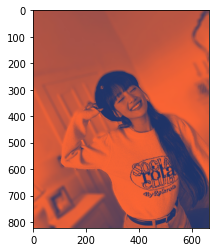

In [155]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* yellow 컬러

(844, 672, 3)


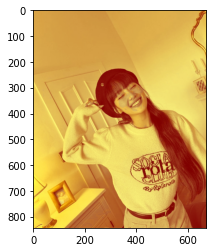

In [156]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/yellow_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [157]:
seg_v, output = model.segmentAsPascalvoc(img_path)

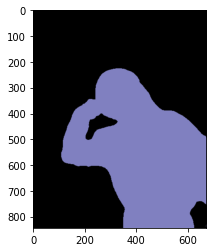

In [158]:
#output 보여주기
plt.imshow(output)
plt.show()

In [159]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [160]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(844, 672)


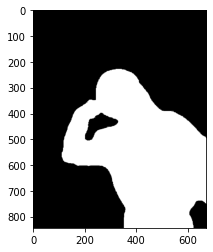

In [161]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

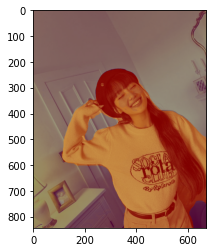

In [162]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

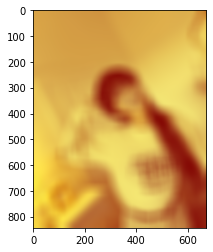

In [166]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

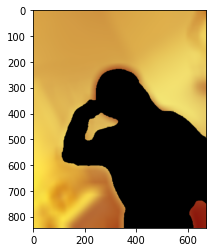

In [167]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

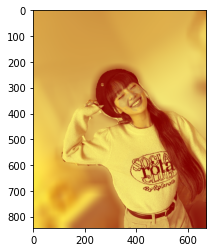

In [168]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* pink 컬러

(826, 658, 3)


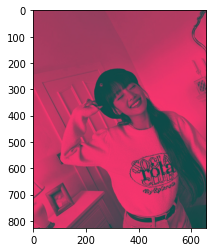

In [169]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pink_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [170]:
seg_v, output = model.segmentAsPascalvoc(img_path)

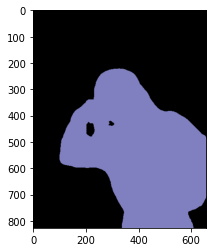

In [171]:
#output 보여주기
plt.imshow(output)
plt.show()

In [172]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [173]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(826, 658)


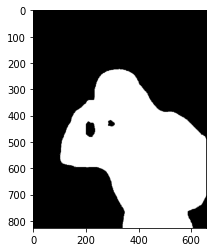

In [174]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

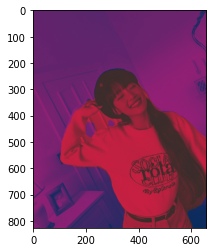

In [175]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

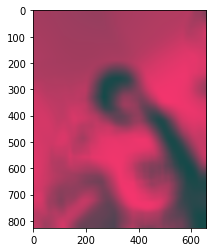

In [177]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (70,70))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

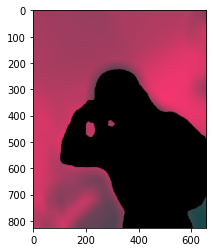

In [178]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

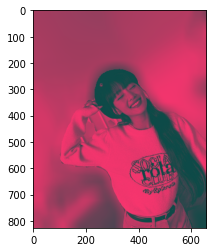

In [179]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* green 컬러

(844, 668, 3)


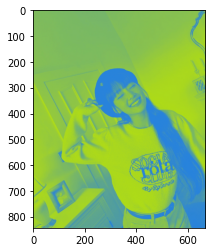

In [180]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/green_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [181]:
seg_v, output = model.segmentAsPascalvoc(img_path)

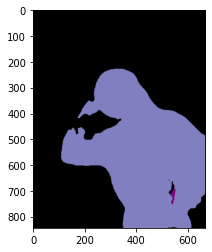

In [182]:
#output 보여주기
plt.imshow(output)
plt.show()

In [183]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0,  5, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [184]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


[192 128 128]
(844, 668)


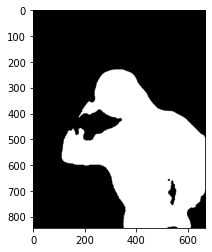

In [185]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

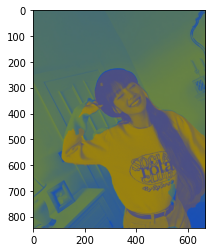

In [186]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

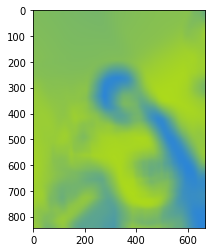

In [187]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (70,70))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

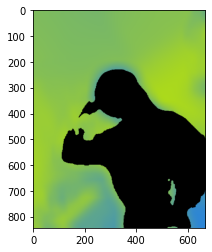

In [188]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

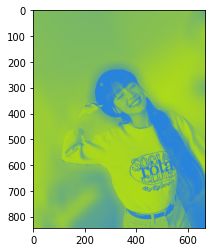

In [189]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* blue color

(832, 666, 3)


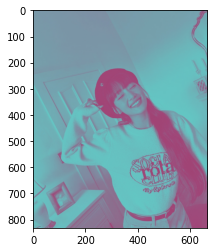

In [190]:
# img path & show image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/blue_color.png'
img_orig = img_orig = cv2.imread(img_path)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### segmentation으로 사람을 분리하기

In [191]:
seg_v, output = model.segmentAsPascalvoc(img_path)

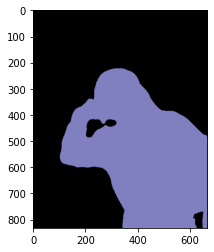

In [192]:
#output 보여주기
plt.imshow(output)
plt.show()

In [193]:
# segmentation value 프린트하기
seg_v

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [194]:
#segvalues에 있는 라벨 프린트하기
for class_id in seg_v['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


[192 128 128]
(832, 666)


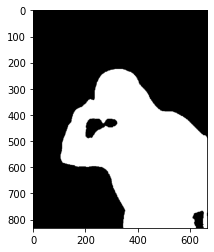

In [195]:
# mask가 씌워진 이미지 프린트하기
seg_map = make_segmap(output)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

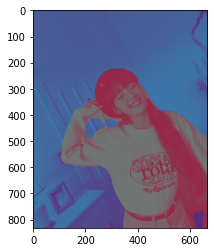

In [196]:
#이미지에서 사람이 있는 위치와 배경을 분리해서 표현한 color_mask를 만든뒤 두 
#이미지를 합쳐서 출력
img_show, img_mask = img_separation(img_orig, seg_map)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

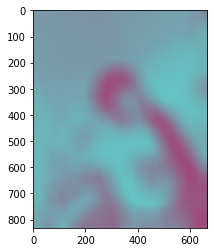

In [200]:
# 배경 흐리게 만들기
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (80,80))
#흐린이미지 보여주기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

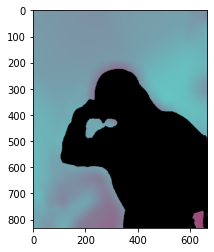

In [201]:
img_mask_color, img_bg_blur = blur_only_bg(img_mask, img_orig_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

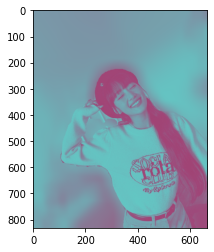

In [202]:
# 블러 처리된 배경과 사람부분 마스크를 합치기!!

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# portrait mode 사진 보여주기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 색깔별에 따른 mask 이미지 나타내기
fig, ax = 

모든색이 사람을 인식하기는 하지만 색이 달라지면서 어떤 색은 제대로 인식하기도 하나 대부분의 색들이 제대로 인식을 못하는 것 같다.

### 느낀점
* 아쉬운 점: 더 다양하게 실험해보고 싶었으나 사진모으는데에 시간을 너무 많이 써버린것같다. 사람이 아닌 다른 물체도 실험해보고싶다.
* 사실 색은 바뀌어도 사람의 모습만 보이면 제대로 인식하지 않을까 싶었는데 아니었다는 결과를 알게되어 굉장히 신기했다.
* 위의 배경의 복작성에 따라 한 결과에 따라서 사람이 많은 사진들에서는 배경의 복잡도에 따라 결과가 달라질 수도 있을 것이라고 생각했다 하지만 오히려 사람의 수가 결과에 많은 영향을 미치는 것 같다.